In [126]:
from astropy.io import ascii
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt

In [134]:
query = f"SELECT phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source\
        WHERE parallax_over_error > 10\
        AND phot_g_mean_flux_over_error>50\
        AND phot_rp_mean_flux_over_error>20\
        AND phot_bp_mean_flux_over_error>20\
        AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND visibility_periods_used>8\
        AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"

job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')
#3000000????

ascii.write(results, 'results.dat', overwrite=True)

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 3000000


In [164]:
query = f"SELECT COUNT(bp_rp) FROM gaiadr2.gaia_source\
        WHERE parallax_over_error > 10\
        AND phot_g_mean_flux_over_error>50\
        AND phot_rp_mean_flux_over_error>20\
        AND phot_bp_mean_flux_over_error>20\
        AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND visibility_periods_used>8\
        AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"
job     = Gaia.launch_job_async(query)
results = job.get_results()
print(results)

#65921112


INFO: Query finished. [astroquery.utils.tap.core]
 COUNT  
--------
65921112


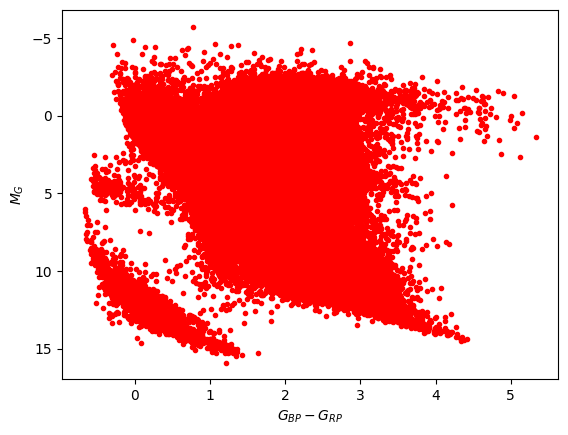

In [135]:
results = ascii.read("results.dat") 

fig, ax = plt.subplots()
ax.invert_yaxis()
ax.set_xlabel(r'$G_{BP}-G_{RP}$')
ax.set_ylabel(r'$M_{G}$')

ax.plot(results['bp_rp'], results['mg'], 'r.')
plt.show()

In [167]:
from scipy.stats import gaussian_kde
import numpy as np

x = results['bp_rp']
y = results['mg']                                  

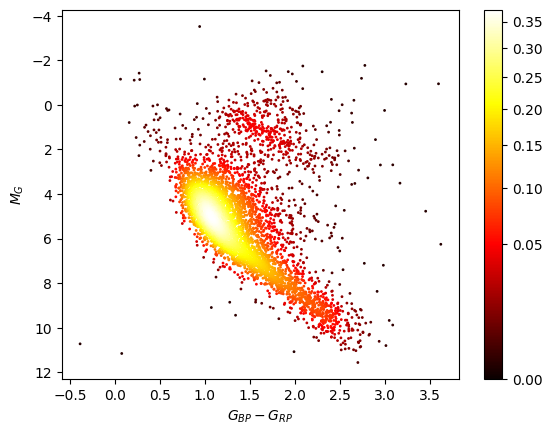

In [139]:
#very slow

import matplotlib.colors as colors
from astropy.visualization import PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.5))

# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
z = gaussian_kde(data)(data)

idx = z.argsort()                                                  
x2, y2, z = x[idx], y[idx], z[idx]  

fig, ax = plt.subplots()

ax.invert_yaxis()
ax.set_xlabel(r'$G_{BP}-G_{RP}$')
ax.set_ylabel(r'$M_{G}$')

s = ax.scatter(                                                     
    x2, y2, c=z, s=1, norm=norm, cmap='hot', label=None, picker=True, zorder=2                
)
plt.colorbar(s)
plt.show()

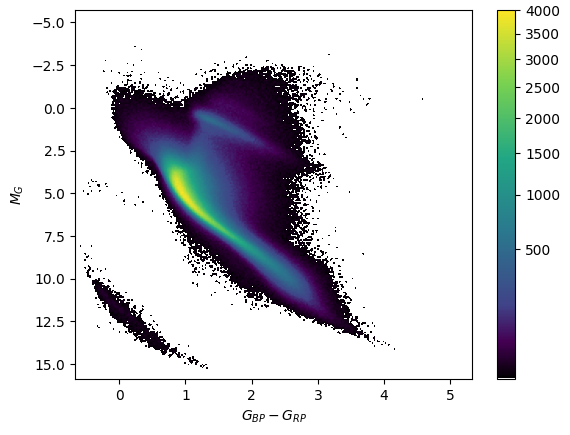

In [153]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#000000'),
    (0.1, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

norm = ImageNormalize(vmin=1, stretch=PowerStretch(0.5))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
ax.set_xlabel(r'$G_{BP}-G_{RP}$')
ax.set_ylabel(r'$M_{G}$')
density = ax.scatter_density(x, y, cmap=white_viridis, norm=norm)
ax.invert_yaxis()
fig.colorbar(density, label='')
plt.show()

In [184]:
query = f"SELECT phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr3.gaia_source\
        WHERE parallax_over_error > 10\
        AND phot_g_mean_flux_over_error>50\
        AND phot_rp_mean_flux_over_error>20\
        AND phot_bp_mean_flux_over_error>20\
        AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)\
        AND visibility_periods_used>8\
        AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))\
        AND (bp_rp - phot_g_mean_mag)/2.285 < 0.015"

job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')

ascii.write(results, 'results_3.dat', overwrite=True)

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 3000000


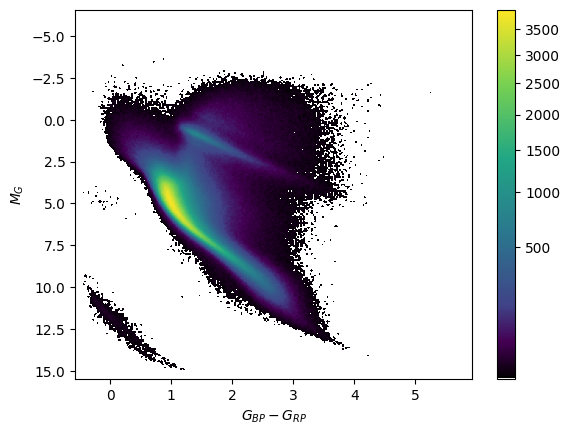

In [186]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#000000'),
    (0.1, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

#results = ascii.read("results_3.dat") 
x = results['bp_rp']
y = results['mg']   

norm = ImageNormalize(vmin=1, stretch=PowerStretch(0.5))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
ax.set_xlabel(r'$G_{BP}-G_{RP}$')
ax.set_ylabel(r'$M_{G}$')
density = ax.scatter_density(x, y, cmap=white_viridis, norm=norm)
ax.invert_yaxis()
fig.colorbar(density, label='')
plt.show()